# 呼叫 Teachable Machine 的模型，完成剪刀、布、石頭的遊戲

這份文件說明如何呼叫 [Google teachable machine](https://teachablemachine.withgoogle.com/)所匯出的模型。

我們示範的是呼叫 image project 所輸出的模型 (下圖紅框處)

![](https://i.imgur.com/agSMIia.png)

在 Teachable machine 訓練好模型後，請匯出模型。

然後將模型存在硬碟中。

在這個例子中，我們示範如何用模型來完成剪刀、石頭、布遊戲的判定。

詳細的文件，可以參考[這兒](https://hackmd.io/@justim/Hyc7WeILI)。

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow.keras
from PIL import Image, ImageOps
from matplotlib.pyplot import imshow
import numpy as np

## 載入模型

In [0]:
# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = tensorflow.keras.models.load_model('keras_model.h5')


## 呼叫 Javascript 存取 webcam 並且拍照

In [0]:
#存取 webcam，並產生拍照的功能
#拍照後會存取 photo.jpg 這個檔名
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
#這段程式碼是模擬 「我方出拳」的狀況。
#它會呼叫 take_photo() 這段程式碼，然後在畫面上秀出拍照的功能。
def Ourturn():
  try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
      
    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

## 取得我們出拳的結果

底下的程式碼會將拍照的結果丟給我們訓練好的 model 中。

然後解析出我們出拳的結果。

出拳的結果是一個串列，裏面是每種可能性的機率。

In [0]:
# 這段程式碼會讀取 webcam 所拍的照片 (檔名為 photo.jpg) (第10行)
# 然後丟給 teachable machine 的模型判讀 (第 32 行)
# 第 10 行到第 32 行間，都是照片的處理。簡單來說，就是把 2 維的照片，裏面的每一個
# 像素都轉化為 teachable machine 所讀得懂的格式，然後再餵給模型。
def getOurResult():
  # Create the array of the right shape to feed into the keras model
  # The 'length' or number of images you can put into the array is
  # determined by the first position in the shape tuple, in this case 1.
  data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

  # Replace this with the path to your image
  image = Image.open('photo.jpg')

  #resize the image to a 224x224 with the same strategy as in TM2:
  #resizing the image to be at least 224x224 and then cropping from the center
  size = (224, 224)
  image = ImageOps.fit(image, size, Image.ANTIALIAS)

  #turn the image into a numpy array
  image_array = np.asarray(image)

  # display the resized image
  %matplotlib inline
  imshow(image_array)
  image.show()

  # Normalize the image
  normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

  # Load the image into the array
  data[0] = normalized_image_array

  # run the inference
  prediction = model.predict(data)
  return prediction


## 測試一下到目前為止的成果

底下三行程式碼可以測試我們的成果。

1. 呼叫 webcam 拍照
2. 將照片丟給模型判讀，並回傳結果。回傳的結果存在 out 這個變數中。
3. 將 out 印出來。

<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable
[[0.9919762  0.0000003  0.00802349]]


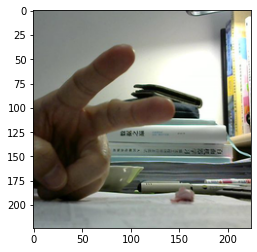

In [0]:
Ourturn()
out = getOurResult()
print(out)

## 明確地判斷我們出拳的結果

上面的程式碼單純地回傳機率。  
但是我們需要的是「我們倒底出了什麼結果？」

numpy 有一個函式可以把向量中最大值所在的「位置」取出來。

<font color="red">請注意，不是最大值喔，是最大值的「位置」</font>

這個函式叫 argmax。

以 [**0.9919762**  0.0000003  0.00802349] 為例，它會回傳 0，因為最大值在 0 的地方。

以 [0.07402386 **0.925976**   0.00000026] 為例，它會回傳 1，因為最大值的位置在 1 的地方。

<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable
[0.00000047 0.00000039 0.99999917]
2


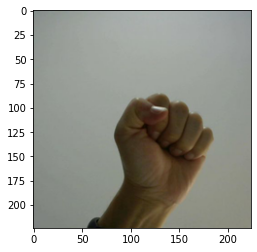

In [0]:
Ourturn()
out = getOurResult()
print(out[0])
o = np.argmax(out[0])
print(o)

## 讓電腦隨機出拳

接著我們要讓電腦隨機出拳。

在 Python 中，我們可以使用 random 這個套件。

random 套件中有 randint(start, end) 這個函式，可以在 [start, end] 這個區間中隨機挑一個數字。

例如 randint(0, 2) 就會在 [0, 2] 之間挑個數字出來。

In [0]:
import random
# c 代表電腦出拳的結果
# 0--剪刀
# 1--石頭
# 2--布
c = random.randint(0,2)
print(c)

0


## 印出有意義的結果

前面的程式碼中，不管是我們出拳，電腦出拳，結果都是 0, 1, 2 這樣的數字。

但我們希望用剪刀，石頭，布的方式來印出來。

底下的程式碼示範如何做到。

In [0]:
# rname 是一個對照表，代表剪刀、石頭、布
# rname[0] 代表 scissor
# rname[1] 代表 paper
# rname[2] 代表 rock
rname = ['scissor', 'paper', 'rock']
#電腦出拳
c = random.randint(0, 2)
#電腦出拳的結果
print(f'電腦出拳 {c}, 它出的是 {rname[c]}')

電腦出拳 2, 它出的是 rock


我們的出拳也可以用類似的方式得到。

<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable
[0.9994128  0.00046671 0.00012056]
我們的出拳是 0，結果是 scissor


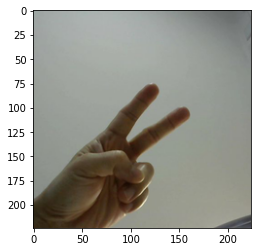

In [0]:
Ourturn()
out = getOurResult()
print(out[0])
o = np.argmax(out[0])
print(f'我們的出拳是 {o}，結果是 {rname[o]}')

In [50]:
!pip install emoji

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=40713d4213f5d4738437b50584fe02c276937fc753115b28ae52a131be0181d0
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


第 1 次玩


<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable
我方出拳為👊
電腦出拳為✋
我輸了
共玩了 1 次，我勝 0 次，電腦勝 1
第 2 次玩


<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable
我方出拳為✌
電腦出拳為✋
我贏了
共玩了 2 次，我勝 1 次，電腦勝 1
第 3 次玩


<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable
我方出拳為✋
電腦出拳為✋
平手
共玩了 3 次，我勝 1 次，電腦勝 1
第 4 次玩


<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable
我方出拳為✋
電腦出拳為👊
我贏了
共玩了 4 次，我勝 2 次，電腦勝 1
第 5 次玩


<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable
我方出拳為✌
電腦出拳為✌
平手
共玩了 5 次，我勝 2 次，電腦勝 1
第 6 次玩


<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable
我方出拳為✋
電腦出拳為✋
平手
共玩了 6 次，我勝 2 次，電腦勝 1
第 7 次玩


<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable
我方出拳為✌
電腦出拳為✋
我贏了
共玩了 7 次，我勝 3 次，電腦勝 1
我勝電腦！


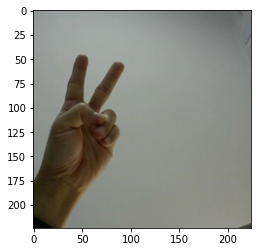

In [51]:
import emoji
#猜拳的結果
outcome = ['scissor', 'paper', 'rock']
emojisymbol = [':v:',':hand:',':punch:']
oursWins = 0
compWins = 0
counts = 1
while True:
  print(f'第 {counts} 次玩')
#電腦先出拳
  o = random.randint(0,2) 
#print(f'電腦出拳為 {outcome[o]}')

  #我方出拳
  Ourturn()
  ours = getOurResult()
  r = np.argmax(ours)

  print('我方出拳為' + emoji.emojize(emojisymbol[r], use_aliases=True))
  print('電腦出拳為' + emoji.emojize(emojisymbol[o], use_aliases=True))

  if r == o: 
    print("平手")
  elif (r+1) % 3 == o:
    print("我贏了")
    oursWins = oursWins + 1
  else:
    print("我輸了")
    compWins = compWins + 1
  
  print(f'共玩了 {counts} 次，我勝 {oursWins} 次，電腦勝 {compWins}')
  counts = counts + 1
  #clear_output(wait=True)
  if oursWins >= 3:
    print("我勝電腦！")
    break
  elif compWins >= 3:
    print("電腦勝")
    break
